# 1 Problem formulation


Using the MLEnd London Sounds dataset, build a machine learning pipeline that takes as an input an audio segment and predicts whether the audio segment has been recorded indoors or outdoors. We consider this as a binary classification problem with labels indoor and outdoor.


# 2 Machine Learning pipeline

We will input the audio files and extract the feature from the audios. 
Split this data into train and test set.
Use standard scalar to normalize the data.
Fit SVC and Logistic Regression model on the training set and compare their performance and choose the best model.
Run the model on test dataset to evaluate model performance on unseen data.

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline1 = Pipeline(steps=[("scaler", StandardScaler()), ("classifier", SVC())])
pipeline2 = Pipeline(steps=[("scaler", StandardScaler()), ("classifier", LogisticRegression())])

# 3 Transformation stage


As input we have Audio (.wav) files and each audio file contains thousands of features it is difficult to train a model and make predictions. So we will first extract features from the audio file using the Librosa library to create a feature vector that we can use to train our ML model. 
Following are the feature used for training:
power,
pitch_mean,
pitch_std,
voiced_fr,
spectral bandwidth,
spectral rolloff,
rms_mean,
Mel-frequency cepstral coefficients mean


After doing this feature extraction we will have X and y, where X will have the features and y will be having the labels.







In [18]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [17]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    yi = labels_file.loc[fileID]['in_out']=='indoor'

    fs = None # if None, fs would be 22050
    try:
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      spec_bw = librosa.feature.spectral_bandwidth(y=x, sr=fs)
      spec_rolloff = librosa.feature.spectral_rolloff(y=x, sr=fs)
      rms = librosa.feature.rms(y=x)
      mfcc = librosa.feature.mfcc(y=x, sr=fs)
        
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)
      spec_bw = np.mean(spec_bw)
      spec_rolloff = np.mean(spec_rolloff)
      rms_mean = np.mean(rms)
      mfcc_mean = np.mean(mfcc)

      xi = [power,pitch_mean,pitch_std,voiced_fr,spec_bw,spec_rolloff,rms_mean,mfcc_mean]
      X.append(xi)
      y.append(yi)
    except:
      print("An exception occurred in",file_name)

  return np.array(X),np.array(y)

# 4 Modelling


The models we will build are SVM and Logistic Regression and compare their performance on our dataset. Logistic regression and support vector machines are both supervised machine learning algorithms. They both are used to solve classification problems.

# 5 Methodology

The model's performance will be assessed by the training accuracy, validation accuracy. We will do cross validation to see the model performance. We will plot the confusion matrix to evaluate the model and see where it is misclassifying the data.

# 6 Dataset


Our dataset contains 2500 audio files. We will try to predict whether the recordings of the audio was done indoors or outdoors.

In [5]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

In [ ]:
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

In [ ]:
url  = "https://collect.qmul.ac.uk/down?t=610I73D2G2RLS4BI/R8RDLM2R3O9FHEMR92GKGR0"
save_path = '/content/drive/MyDrive/Data/MLEndLS/MLEndLS_Sample.zip'
download_url(url, save_path)

In [ ]:
path = '/content/drive/MyDrive/Data'
os.listdir(path)

['MLEndLS',
 'MLEndLS_2.zip',
 'MLEndLS_1',
 'MLEndLS_3.zip',
 'MLEndLS_4.zip',
 'MLEndLS_1.zip',
 'MLEndLS_5.zip']

In [ ]:
directory_to_extract_to = '/content/drive/MyDrive/Data/MLEndLS/'
zip_path = '/content/drive/MyDrive/Data/MLEndLS.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [22]:
sample_path = '/content/drive/MyDrive/Data/MLEndLS/*.wav'
files = glob.glob(sample_path)
len(files)

2498

In [23]:
for _ in range(5):
  n = np.random.randint(98)
  display(ipd.Audio(files[n]))

In [21]:
MLENDLS_df = pd.read_csv('./MLEndLS.csv').set_index('file_id') 
MLENDLS_df

area       spot   in_out Participant
file_id                                             
0001.wav     british     street  outdoor        S151
0002.wav  kensington   dinosaur   indoor        S127
0003.wav      campus     square  outdoor         S18
0004.wav  kensington     hintze   indoor        S179
0005.wav      campus     square  outdoor        S176
...              ...        ...      ...         ...
2496.wav     westend  trafalgar  outdoor        S151
2497.wav      campus     square  outdoor          S6
2498.wav     westend   national   indoor         S96
2499.wav     british     room12   indoor         S73
2500.wav     british     room12   indoor         S58

[2500 rows x 4 columns]

In [ ]:
X,y = getXy(files, labels_file=MLENDLS_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 999/999 [30:11<00:00,  1.81s/it]


In [25]:
df = pd.DataFrame(X,columns = ['power','pitch_mean','pitch_std','voiced_fr','spec_bw','spec_rolloff','rms_mean','mfcc_mean'])
df['target'] = y
print('The shape of X is', X.shape) 
print(type(X))
print('The shape of y is', y.shape)
#print('The labels vector is', y)

The shape of X is (2362, 8)
<class 'numpy.ndarray'>
The shape of y is (2362,)


In [2]:
import pandas as pd

df = pd.read_csv('MLEnd_df_4.csv')
df.info()
y =df['target']
X = df.drop('target',axis = 1).values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2497 entries, 0 to 2496
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   power         2497 non-null   float64
 1   pitch_mean    2497 non-null   float64
 2   pitch_std     2497 non-null   float64
 3   voiced_fr     2497 non-null   float64
 4   spec_bw       2497 non-null   float64
 5   spec_rolloff  2497 non-null   float64
 6   rms_mean      2497 non-null   float64
 7   mfcc_mean     2497 non-null   float64
 8   target        2497 non-null   bool   
dtypes: bool(1), float64(8)
memory usage: 158.6 KB


In [6]:
print(' The number of indoor recordings is ', np.count_nonzero(y))
print(' The number of outdoor recordings is ', y.size - np.count_nonzero(y))


 The number of indoor recordings is  1181
 The number of outdoor recordings is  1316


As we can observe the number of outdoor data is more than indoor, so we can try to balance the dataset by randomly select ony 1181 records from the outdoor reocrding sp balance the dataset.

In [9]:
indoor_df = df[df['target'] == True].sample(n=1181,random_state=42)

outdoor_df = df.loc[df['target'] == False].sample(n=1181,random_state=42)

df = pd.concat([indoor_df, outdoor_df])
y = df['target'].values
X = df.drop('target',axis = 1).values


In [29]:
print(' The number of indoor recordings is ', np.count_nonzero(y))
print(' The number of outdoor recordings is ', y.size - np.count_nonzero(y))

 The number of indoor recordings is  1181
 The number of outdoor recordings is  1181


In [30]:
df

power  pitch_mean  pitch_std  voiced_fr      spec_bw  spec_rolloff  \
1681  0.010074   95.068484   3.053971   0.038328  1825.888684   2438.679021   
2049  0.005643  201.337086  12.214085   0.109231  3004.239949   3606.977163   
2231  0.005415  151.922807  12.611644   0.174900  3517.360647   5049.349263   
173   0.011922  227.257763  35.762043   0.079491  2126.231267   3754.480000   
1995  0.006024  195.189920  22.814062   0.042846  1943.787195   2725.769290   
...        ...         ...        ...        ...          ...           ...   
1118  0.025244  150.684711   8.555524   0.081831  1696.258004   2295.152742   
2073  0.015643  109.143091  13.487213   0.037889  2408.172813   3102.558686   
1007  0.038156   86.984323   2.394384   0.034426  2501.670819   2385.631804   
1990  0.007997    0.000000   0.000000   0.000000  4195.582435   6633.680138   
1043  0.005870   87.496422   2.840053   0.067114  2182.961219   1616.001861   

      rms_mean  mfcc_mean  target  
1681  0.089291  -2.175031    True  
2049  0.056666  -5.880852    True  
2231  0.048682  -4.339999    True  
173   0.103681  -0.501720    True  
1995  0.068407  -2.394723    True  
...        ...        ...     ...  
1118  0.154300   1.589038   False  
2073  0.115920   1.554423   False  
1007  0.187586   4.234213   False  
1990  0.080292   1.425864   False  
1043  0.060694  -2.676318   False  

[2362 rows x 9 columns]

Now plot correlation metrics to understand our data better. 

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text major ticklabel objects>)

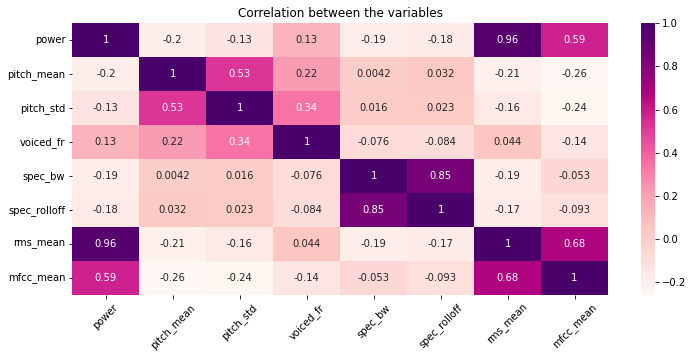

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(figsize=(12,5))
correlation=df.drop('target',axis = 1).corr()
sns.heatmap(correlation,annot=True,cmap='RdPu')
plt.title('Correlation between the variables')
plt.xticks(rotation=45)

(array([258., 324., 150.,  87.,  40.,  21.,  13.,  13.,   5.,   3.]),
 array([0.00043316, 0.00682932, 0.01322549, 0.01962165, 0.02601781,
        0.03241397, 0.03881013, 0.0452063 , 0.05160246, 0.05799862,
        0.06439478]),
 <a list of 10 Patch objects>)

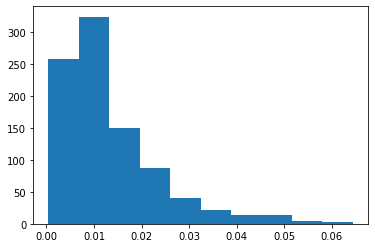

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.hist(df['power'])

Plotting the features with high positive correlation to visualize them

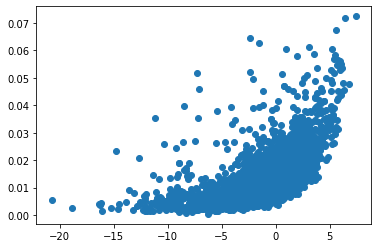

In [32]:
plt.scatter(df["mfcc_mean"], df['power'])

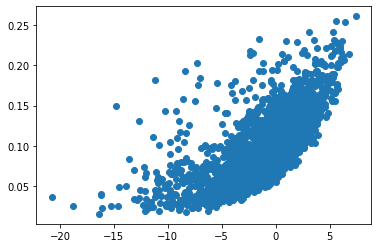

In [33]:
plt.scatter(df["mfcc_mean"], df['rms_mean'])

# 7 Results

First running the SVM to establish a baseline model without normalizing the dataset.

In [63]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

model  = svm.SVC(C=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_test)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_test))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.5656382335148216
Validation  Accuracy 0.5811001410437235
The support vectors are (1520, 8)


In [64]:
#Fitting training data to pipeline1 
pipeline1.fit(X_train, y_train)
pipeline1.score(X_test,y_test)

0.7503526093088858

In [65]:
#Fitting training data to pipeline2
pipeline2.fit(X_train, y_train)
pipeline2.score(X_test,y_test)

0.7038081805359662

In [91]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline1, X_train, y_train, scoring='accuracy', cv=10)
print("SVM model:",np.mean(scores))
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline2, X_train, y_train, scoring='accuracy', cv=10)
print("Logistice regression:",np.mean(scores))

SVM model: 0.7065972982840454
Logistice regression: 0.7005403431909457


We observe almost same accuracy when doing the cross validation on both models. Let try to plot confusion matrix to see the number of false positive and false negatives to evaluate our models futher.

confusion matrix for train data for Pipeline 2
              precision    recall  f1-score   support

       False       0.69      0.74      0.72       828
        True       0.72      0.67      0.70       825

    accuracy                           0.71      1653
   macro avg       0.71      0.71      0.71      1653
weighted avg       0.71      0.71      0.71      1653



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


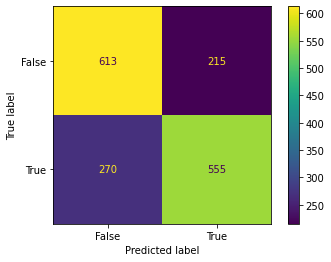

In [86]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix,classification_report
print("confusion matrix for train data for Pipeline 2")
plot_confusion_matrix(pipeline2,X_train, y_train,values_format='d' )
print(classification_report(y_train,pipeline2.predict(X_train)))

confusion matrix for train data for pipeline1


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

       False       0.73      0.82      0.77       828
        True       0.79      0.69      0.74       825

    accuracy                           0.75      1653
   macro avg       0.76      0.75      0.75      1653
weighted avg       0.76      0.75      0.75      1653



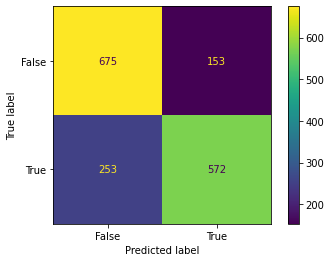

In [87]:
print("confusion matrix for train data for pipeline1")
plot_confusion_matrix(pipeline1,X_train, y_train,values_format='d' )
print(classification_report(y_train,pipeline1.predict(X_train)))

# 8 Conclusions

We can see SVM seems to perform better for this particular dataset. Let's run the model on our test dataset. 

confusion matrix for test data
              precision    recall  f1-score   support

       False       0.73      0.80      0.76       353
        True       0.78      0.70      0.74       356

    accuracy                           0.75       709
   macro avg       0.75      0.75      0.75       709
weighted avg       0.75      0.75      0.75       709



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


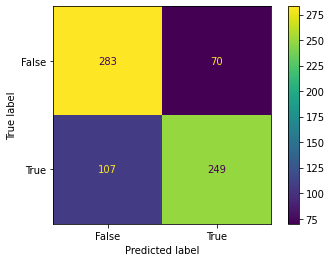

In [92]:
print("confusion matrix for test data")
plot_confusion_matrix(pipeline1,X_test, y_test,values_format='d' )
print(classification_report(y_test,pipeline1.predict(X_test)))

We are able to achieve 75% accuracy using SVM model on our dataset.